# association_analysis


挖掘葡萄酒数据集中的频繁项集和关联规则，主要实现的内容如下：
1. 分析数据集中的标称属性和数值属性，对数值属性进行离散化处理转化为标称属性，接着对属性值进行编码  
2. 对编码后的数据使用FP-growth算法挖掘频繁项集，然后利用深度优先遍历由频繁项集产生关联规则  
3. 使用Lift和卡方检验两种评估策略评估关联规则，并绘制了散点图和热力图进行可视化分析 

## wine-reviews(葡萄酒数据)

各字段含义：

评分（Points）：评分为1-100

品种（Variety）：用来制作葡萄酒的葡萄品种

描述（Description）：侍酒师的几句话描述酒的味道，气味，外观，感觉等。

国家（Country）：葡萄酒来自的国家

省（Province）：葡萄酒来自的省份或州

区域1（Region 1）：一个省或州的葡萄酒产区

区域2（Region 2）：有时在葡萄酒产区内有更具体的区域，但是这个值有时可能是空白的

酒庄（Winery）：酿酒的酿酒厂

名称（Designation）：葡萄酒酿造厂所在的葡萄园

价格（Price）：一瓶葡萄酒的价格

数据集中有两个离散属性，points(葡萄酒评分)和price(葡萄酒的价格)，需要分别对其离散化


In [65]:
import pandas as pd

data = pd.read_csv('winemag-data_first150k.csv', index_col=0)

## 数据列
葡萄酒描述不是标称数据也不是数值数据，因此可以删去  
对其余字段的每个值进行编号，方便寻找频繁项集

In [66]:
data.drop(['description'], axis=1, inplace=True)
data.drop_duplicates(inplace=True)

## points属性数据分布

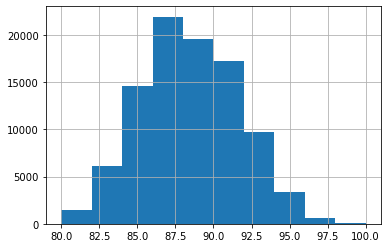

In [67]:
data['points'].hist()

## points属性离散化  
points整体服从正态分布，范围为80-100，将其划分为4个分段  
  * 95-100 A
  * 90-95 B
  * 85-90 C
  * 80-85 D

In [68]:
# 映射函数
def points_map(x):
    if x >= 95:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x >= 85:
        return 'C'
    else:
        return 'D'
    
data['points'] = data['points'].map(points_map)
data.head(5)

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,A,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,A,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,A,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,A,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,A,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
5,Spain,Numanthia,A,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia
6,Spain,San Román,A,65.0,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos
7,Spain,Carodorum Único Crianza,A,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
8,US,Silice,A,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,A,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


## price频数分布直方图（0-200）  
位于0-200的price占整体数据的比例为90%，说明大部分的价格数据在200以内，绘制200以内的价格分布直方图。
可以看到0-25数据频数最大，随着价格升高，频数逐步降低

位于0-200的price占整体数据的比例 0.9062411063444045


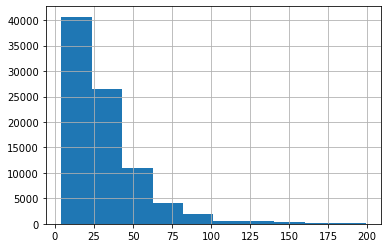

In [69]:
# 位于0-200的price占整体数据的比例
print('位于0-200的price占整体数据的比例', (data.price < 200).sum(axis=0)/data.shape[0])
# 绘制0-200的聘书分布直方图
data.loc[data.price < 200, 'price'].hist()

## price属性离散化  

划分为5个价格区间:  
* 200以上：a
* 100-200: b
* 60-100: c
* 25-60: d
* 0-25: e

In [70]:
# 映射函数
def points_map(x):
    if x >= 200:
        return 'a'
    elif x >= 100:
        return 'b'
    elif x >= 60:
        return 'c'
    elif x >= 25:
        return 'd'
    else:
        return 'e'
    
data['price'] = data['price'].map(points_map)
data.head(10)

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,A,a,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,A,b,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,A,c,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,A,c,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,A,c,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
5,Spain,Numanthia,A,c,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia
6,Spain,San Román,A,c,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos
7,Spain,Carodorum Único Crianza,A,b,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
8,US,Silice,A,c,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,A,c,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


## 各标称属性值计数

In [71]:
data.apply(lambda x: x.value_counts().size)

country           48
designation    30621
points             4
price              5
province         455
region_1        1236
region_2          18
variety          632
winery         14810
dtype: int64

## 取出数据集中所有不重复的元素，以对其编码

In [72]:
columns = data.columns
nums = []
cols = []
for col in columns:
    value = data[col]
    value = value[value.notnull()].unique()
    nums.extend(value)
    cols.extend([col]*len(value))
    
val_col = pd.DataFrame({'values': nums, 'cols': cols})
len(val_col)

47829

## 产生8位的随机字符串编码（字母和数字组合）

In [73]:
import random, string
codes = set()
while len(codes) < len(val_col):
    ran_str = ''.join(random.sample(string.ascii_letters + string.digits, 8))
    codes.add(ran_str)

## 对不重复元素进行字符串编码

In [74]:
val_col['codes'] = list(codes)
val_col.head(10)

,values,cols,codes
0,US,country,bvnTlDwu
1,Spain,country,HxhcgCkE
2,France,country,qGJY4sDQ
3,Italy,country,VdLAqrZO
4,New Zealand,country,prmdboQR
5,Bulgaria,country,JQYfA80M
6,Argentina,country,MQUOR7W9
7,Australia,country,Tp5DGfF3
8,Portugal,country,a4UJA9LG
9,Israel,country,gHnQ7iEJ


## 值-编码映射字典

In [75]:
groups = val_col.groupby(['cols'])
val_code = {}
for name, group in groups:
    print(name)
    maps = dict(zip(group['values'], group['codes']))
    val_code[name] = maps

country
designation
points
price
province
region_1
region_2
variety
winery


## 按照映射字典对数据进行映射

In [76]:
def val2code(col, val_code):
    return col.map(val_code[col.name])

newdata = data.apply(val2code, args=(val_code, ), axis=0)
print(newdata.head())
# 转换成列表，方便关联分析
newdata = newdata.values.tolist()


# 去除空值
temp = []
for d in newdata:
    temp.append([v for v in d if isinstance(v, str)])
    
newdata = temp

    country designation    points     price  province  region_1  region_2  \
0  bvnTlDwu    RBt8qJfK  yXoVEfbH  5iC4ajz3  VW6r3Y1w  ZAL5JNvX  W4HQ0VYb   
1  HxhcgCkE    jVslyIoh  yXoVEfbH  jdaNA2oI  Ii7NxQnZ  oFJxbGVA       NaN   
2  bvnTlDwu    jI5n0vSM  yXoVEfbH  PMsUtZ1T  VW6r3Y1w  cxpdy9Vl  aSp4GAd7   
3  bvnTlDwu    Nzx3VWng  yXoVEfbH  PMsUtZ1T  Ebp3rt5X  aKs9SRUy  KgInstmq   
4  qGJY4sDQ    kN620wit  yXoVEfbH  PMsUtZ1T  XjsBKYFL  kI2TGlrP       NaN   

    variety    winery  
0  Lv7ty4Fu  2I4HAwhu  
1  mLqv6pNO  7ewoEjms  
2  SajqDfon  WlLXMrxT  
3  BhNGnZpu  ofYdlkUx  
4  rIt1035S  lJ46imuo  


## 将映射编码和处理后的数据保存，方便关联规则挖掘

In [77]:
import csv

val_col.to_csv('val_code.csv', index=False)

# 保存处理后的数据
with open('data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    
    for d in newdata:
        writer.writerow(d)

## 读取处理后的数据

In [3]:
import csv
import pandas as pd

dataset = []
with open('data.csv', 'r') as f:
    reader = csv.reader(f)
    for line in reader:
        dataset.append(line)

## 调用FP-growth函数挖掘频繁项集

调用find_frequent_itemsets()生成频繁项  
minimum_support表示设置的最小支持度，即若支持度大于等于inimum_support，保存此频繁项，否则删除  
include_support表示返回结果是否包含支持度，若include_support=True，返回结果中包含itemset和support，否则只返回itemset

In [5]:
import fp_growth_py3 as fpg

support = 0.08 # 相对支持度
minimum_support = support*len(dataset) # 绝对支持度

frequent_itemsets = fpg.find_frequent_itemsets(dataset, minimum_support=minimum_support, include_support=True)

freq0 = []
for itemset, support in frequent_itemsets:    # 将generator结果存入list
    freq0.append((itemset, support))

# 未解码的频繁项集
pd_freq0 = pd.DataFrame([[item, sup, sup/len(dataset)] for item, sup in freq0], columns=['频繁项集', '绝对支持度', '相对支持度'])
pd_freq0.sort_values(by=['相对支持度'], ascending=False)
pd_freq0.reset_index(inplace=True, drop=True)
print('未解码的频繁项集')
pd_freq0

未解码的频繁项集


,频繁项集,绝对支持度,相对支持度
0,[bvnTlDwu],39168,0.412855
1,"[JbS6h951, bvnTlDwu]",15514,0.163527
2,"[BtsoYam3, bvnTlDwu]",18813,0.198301
3,"[JbS6h951, BtsoYam3, bvnTlDwu]",8833,0.093105
4,[VW6r3Y1w],27900,0.294084
5,"[bvnTlDwu, VW6r3Y1w]",27900,0.294084
6,"[JbS6h951, bvnTlDwu, VW6r3Y1w]",10309,0.108663
7,"[BtsoYam3, bvnTlDwu, VW6r3Y1w]",12748,0.134372
8,"[JbS6h951, VW6r3Y1w]",10309,0.108663
9,"[USqucMhH, VW6r3Y1w]",14098,0.148602


## 由频繁项集生成关联规则(依据规则置信度筛选)

In [6]:
# 深度优先
def dfs(nums, i, x, supports, rules):
    if i==len(nums):
        # 规则左项
        left = tuple([x[j] for j in range(len(x)) if nums[j]==1])
        # 规则右项
        right = tuple([x[j] for j in range(len(x)) if nums[j]==0])
        
        # 选择大于置信度阈值的规则
        if len(left) > 0 and len(right) > 0 and (left in supports) and (right in supports):
            conf = 1.0*supports[x]/supports[left]
            if conf > 0.2:
                rules.append((left, right, supports[x], conf))
        return
    
    for v in [0, 1]:
        nums[i] = v
        dfs(nums, i+1, x, supports, rules)

items = [tuple(freq0[i][0]) for i in range(len(freq0))]
supports = {tuple(freq0[i][0]):1.0*freq0[i][1]/len(dataset) for i in range(len(freq0))}

# 由频繁项集生成关联规则
rules0 = []
# 深度优先遍历项集的子集，生成左项和右项
for item in items:
    dfs([0]*len(item), 0, item, supports, rules0)

print('未解码的规则')
pd_rules0 = pd.DataFrame(rules0, columns=['规则左项', '规则右项', '规则支持度', '规则置信度'])
pd_rules0.sort_values(by=['规则置信度'], ascending=False)
pd_rules0.reset_index(inplace=True, drop=True)
pd_rules0

未解码的规则


,规则左项,规则右项,规则支持度,规则置信度
0,"(bvnTlDwu,)","(JbS6h951,)",0.163527,0.396089
1,"(JbS6h951,)","(bvnTlDwu,)",0.163527,0.303512
2,"(bvnTlDwu,)","(BtsoYam3,)",0.198301,0.480316
3,"(BtsoYam3,)","(bvnTlDwu,)",0.198301,0.380545
4,"(bvnTlDwu,)","(JbS6h951, BtsoYam3)",0.093105,0.225516
...,...,...,...,...
74,"(Rpxfu1I7,)","(JbS6h951,)",0.083039,0.269416
75,"(BtsoYam3,)","(JbS6h951,)",0.332852,0.638752
76,"(JbS6h951,)","(BtsoYam3,)",0.332852,0.617783
77,"(qjh2BCDR,)","(JbS6h951,)",0.120258,0.794388


## 读取编码映射

In [7]:
import pandas as pd
val_code = pd.read_csv('val_code.csv')

code_map = dict(zip(val_code['codes'], val_code[['values', 'cols']].values.tolist()))

## 解码并显示频繁项集

In [8]:
pp = {
    # 评分等级：分数
    'A': '95-100',
    'B': '90-95',
    'C': '85-90',
    'D': '80-85',
    # 价格等级：价格
    'a': '>=200',
    'b': '100-200',
    'c': '60-100',
    'd': '25-60',
    'e': '0-25'
    }

def code2val(item, code_map):
    return tuple('{} = {}'.format(code_map[v][1], pp[code_map[v][0]] if code_map[v][0] in pp else code_map[v][0]) for v in item)


def decode_frequent(freq, code_map, size):
    
    # 依据绝对支持度排序
    freq = sorted(freq, key=lambda x: x[-1], reverse=True)
    newfreq = []
    for itemset, support in freq:
        newfreq.append((code2val(itemset, code_map), support, round(support/size, 4)))
    return newfreq
    
# 对频繁项集解码
freq = decode_frequent(freq0, code_map, len(dataset))

print('解码后的频繁项集')
pd_freq = pd.DataFrame(freq, columns=['频繁项集', '绝对支持度', '相对支持度'])
pd_freq.sort_values(by=['相对支持度'], ascending=False)
pd_freq.reset_index(inplace=True, drop=True)
pd_freq

解码后的频繁项集


,频繁项集,绝对支持度,相对支持度
0,"(price = 0-25,)",51115,0.5388
1,"(points = 85-90,)",49437,0.5211
2,"(country = US,)",39168,0.4129
3,"(price = 25-60,)",33700,0.3552
4,"(price = 0-25, points = 85-90)",31578,0.3329
5,"(points = 90-95,)",29241,0.3082
6,"(province = California,)",27900,0.2941
7,"(country = US, province = California)",27900,0.2941
8,"(country = US, price = 25-60)",19509,0.2056
9,"(points = 85-90, country = US)",18813,0.1983


## 解码并显示关联规则

In [9]:
def decode_rules(rules, code_map):
    rules = sorted(rules, key=lambda x: x[-1], reverse=True)
    newrules = []
    for rule in rules:
        newrules.append((code2val(rule[0], code_map), code2val(rule[1], code_map)) + rule[2:])
    return newrules

# 对关联规则进行解码
rules = decode_rules(rules0, code_map)

print('解码后的规则')
pd_rules = pd.DataFrame(rules, columns=['规则左项', '规则右项', '规则支持度', '规则置信度'])
pd_rules.sort_values(by=['规则置信度'], ascending=False)
pd_rules.reset_index(inplace=True, drop=True)
pd_rules

解码后的规则


,规则左项,规则右项,规则支持度,规则置信度
0,"(province = California,)","(country = US,)",0.294084,1.000000
1,"(price = 0-25, province = California)","(country = US,)",0.108663,1.000000
2,"(points = 85-90, province = California)","(country = US,)",0.134372,1.000000
3,"(price = 25-60, province = California)","(country = US,)",0.148602,1.000000
4,"(points = 90-95, province = California)","(country = US,)",0.093148,1.000000
...,...,...,...,...
74,"(country = US,)","(region_2 = Central Coast,)",0.085643,0.207440
75,"(country = US,)","(province = California, region_2 = Central Coast)",0.085643,0.207440
76,"(country = US,)","(price = 25-60, points = 90-95)",0.084789,0.205372
77,"(price = 0-25,)","(country = US, province = California)",0.108663,0.201682


## 使用Lift评估关联规则  
规则 A => B  
confidence = S(A, B)/S(A)  
Lift = S(A, B)/(S(A)\*S(B)) = confidence/S(B)

In [10]:
def lift_rules(rules0, supports):
    rules = []
    for left, right, sup, conf in rules0:
        rules.append((left, right, sup, conf, conf/supports[right]))

    return rules
    
lifts0 = lift_rules(rules0, supports)
# 解码规则左右项
lifts = decode_rules(lifts0, code_map)


print('使用Lift评估关联规则')
pd_lifts = pd.DataFrame(lifts, columns=['规则左项', '规则右项', '规则支持度', '规则置信度', 'Lift值'])
pd_lifts.sort_values(by=['Lift值'], ascending=False)
pd_lifts.reset_index(inplace=True, drop=True)
pd_lifts

使用Lift评估关联规则


,规则左项,规则右项,规则支持度,规则置信度,Lift值
0,"(province = California,)","(region_2 = Central Coast,)",0.085643,0.291219,3.400394
1,"(province = California,)","(country = US, region_2 = Central Coast)",0.085643,0.291219,3.400394
2,"(country = US, province = California)","(region_2 = Central Coast,)",0.085643,0.291219,3.400394
3,"(region_2 = Central Coast,)","(province = California,)",0.085643,1.000000,3.400394
4,"(region_2 = Central Coast,)","(country = US, province = California)",0.085643,1.000000,3.400394
...,...,...,...,...,...
74,"(province = California,)","(price = 0-25,)",0.108663,0.369498,0.685800
75,"(price = 0-25,)","(province = California,)",0.108663,0.201682,0.685800
76,"(country = US,)","(price = 0-25, points = 85-90)",0.093105,0.225516,0.677526
77,"(price = 0-25, points = 85-90)","(country = US,)",0.093105,0.279720,0.677526


## 使用卡方检验评估关联规则

In [11]:
import numpy as np
# 卡方检验计算公式
def chi_square(v):
    t = np.zeros_like(v)
    t[:, 0] = v.sum(axis=1)*(np.sum(v[:, 0])/np.sum(v))
    t[:, 1] = v.sum(axis=1)*(np.sum(v[:, 1])/np.sum(v))
    return np.sum((t-v)**2/t)
    
# 计算规则的卡方检验值
def cs_rules(rules0, supports, size):
    rules = []
    for left, right, sup, conf, lift in rules0:
        v = np.zeros((2, 2))
        lr = frozenset(left + right)
        v[0, 0] = supports[lr]*size
        v[0, 1] = (supports[frozenset(left)] - supports[lr])*size
        v[1, 0] = (supports[frozenset(right)] - supports[lr])*size
        v[1, 1] = size - v[0, 0] - v[0][1] - v[1, 0]
        cs = chi_square(v)
        rules.append((left, right, sup, conf, lift, cs))

    return rules

spts = {frozenset(k): v for k, v in supports.items()}
cs0 = cs_rules(lifts0, spts, len(dataset))

# 解码规则左右项
cs = decode_rules(cs0, code_map)
    
print('使用卡方检验评估关联规则')
pd_cs = pd.DataFrame(cs, columns=['规则左项', '规则右项', '规则支持度', '规则置信度', 'Lift值', '卡方值'])
pd_cs.sort_values(by=['卡方值'], ascending=False)
pd_cs.reset_index(inplace=True, drop=True)
pd_cs

使用卡方检验评估关联规则


,规则左项,规则右项,规则支持度,规则置信度,Lift值,卡方值
0,"(province = California,)","(country = US,)",0.294084,1.000000,2.422156,56207.994159
1,"(country = US,)","(province = California,)",0.294084,0.712316,2.422156,56207.994159
2,"(price = 25-60, province = California)","(country = US,)",0.148602,1.000000,2.422156,23548.972401
3,"(country = US,)","(price = 25-60, province = California)",0.148602,0.359937,2.422156,23548.972401
4,"(country = US, price = 25-60)","(province = California,)",0.148602,0.722641,2.457264,21727.502578
...,...,...,...,...,...,...
74,"(country = Italy,)","(price = 0-25,)",0.083977,0.553841,1.027945,15.468765
75,"(province = California,)","(points = 90-95,)",0.093148,0.316738,1.027642,13.455021
76,"(points = 90-95,)","(province = California,)",0.093148,0.302213,1.027642,13.455021
77,"(points = 90-95,)","(country = US, province = California)",0.093148,0.302213,1.027642,13.455021


## 四项指标可视化

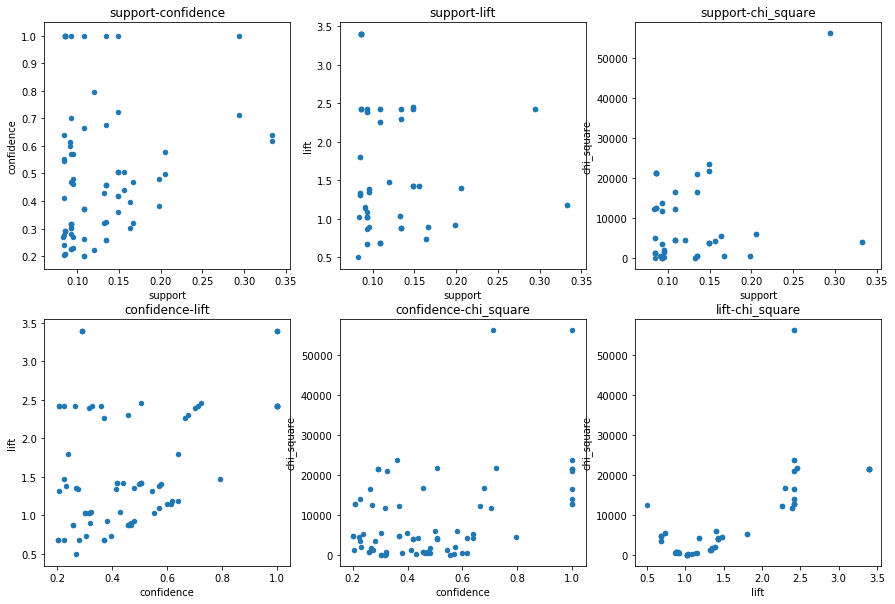

In [12]:
import matplotlib.pyplot as plt
# 支持度和置信度和Lift
list_cs = pd.DataFrame(cs, columns=['left', 'right', 'support', 'confidence', 'lift', 'chi_square'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# 支持度和lift

k = 0
measures = ['support', 'confidence', 'lift', 'chi_square']
for i in range(len(measures)):
    for j in range(i+1, len(measures)):
        list_cs.plot.scatter(x=measures[i], y=measures[j], ax=axes[k//3][k%3])
        axes[k//3][k%3].set_title('{}-{}'.format(measures[i], measures[j]))
        k += 1

## Lift和卡方值分布图

Text(0.5, 1.0, 'support-confidence-chi_square')

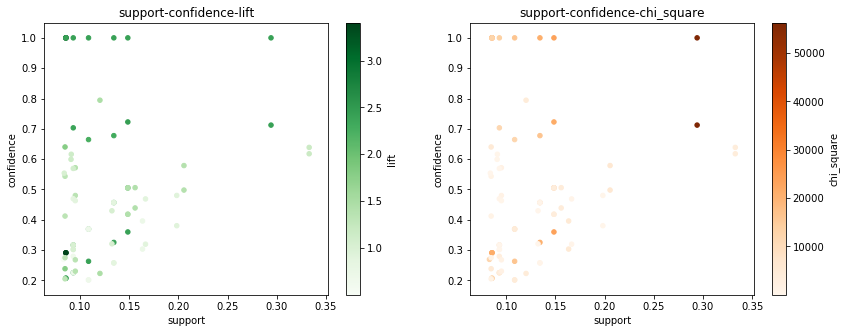

In [13]:
fig, axe = plt.subplots(1, 2, figsize=(14, 5))
list_cs.plot.scatter(x = 'support', y='confidence', c='lift', cmap='Greens', ax=axe[0])
axe[0].set_title('support-confidence-lift')
list_cs.plot.scatter(x = 'support', y='confidence', c='chi_square', cmap='Oranges', ax=axe[1])
axe[1].set_title('support-confidence-chi_square')